# Tech Challenge - Fase 1 - Grupo 19

## Modelo preditivo de custos em seguro saúde

*O objetivo deste notebook é realizar previsões utilizando os modelos LinearRegression, DecisionTreeRegressor, RandomForestRegressor GradientBoostingRegressor e HuberRegressor e identificar o modelo que apresente o melhor resultado na previsão dos encargos médicos com base em dados pessoais.*

### Sumário
1. Estudo da base de dados
2. Pré-processamento dos dados
3. Estratificação das bases de treino e teste
4. Execução e avaliação de vários modelos
5. Insights e melhorias, re-execução do passo 4

### Conclusões e Resultados
- Inicialmente, os modelos testados não tiveram um bom resultado (MAPE na casa dos 30%)
- Analisando a base de dados, identificamos que o modelo performa melhor prevendo custos abaixo de 17 mil. Isso devido a baixa ocorrência de valores acima desse patamar (apenas 25%)
- Foram testadas 2 estratégias para contornar a situação:
    - Retirar da amostra os registros com encargo maior que 17 mil (equivalente ao 3º quartil da base)
    - Executar um "upsampling" na amostra para que o modelo aprenda a prever custos maiores que esse valor
- **Veredito: A segunda estratégia parece mais adequada por atingir uma boa taxa de acerto sem descartar parte da amostra**

---



### Agrupando os imports necessários

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Exploração da base de dados

Observações a respeito da base:
- 1338 registros, sem entradas nulas
- as colunas "gênero", "fumante" e "região" tem dados não-numéricos
- a distribuição de valores de imc aparenta uma curva normal
- 75% da base apresenta o valor da coluna "encargos" abaixo de 17mil
- o valor máximo de "encargos" é 63770, bem distante da média que é 13270

In [2]:
dataset = pd.read_csv('archive/insurance.csv')

#### 1.1 Exibindo a quantidade de linha e colunas do dataset

In [3]:
dataset.shape

(1338, 7)

#### 1.2 Análise de valores nulos e duplicados

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     1338 non-null   int64  
 1   gênero    1338 non-null   object 
 2   imc       1338 non-null   float64
 3   filhos    1338 non-null   int64  
 4   fumante   1338 non-null   object 
 5   região    1338 non-null   object 
 6   encargos  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
dataset.duplicated().sum()

1

#### 1.2 Exibição das primeiras linhas do conjunto de dados

In [6]:
dataset.head()

,idade,gênero,imc,filhos,fumante,região,encargos
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### 1.3 Resumo estatístico das colunas numéricas

In [7]:
dataset.describe()

,idade,imc,filhos,encargos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### 1.4 Histograma das colunas numéricas, idade, imc, filhos e encargos

array([[<Axes: title={'center': 'idade'}>,
        <Axes: title={'center': 'imc'}>],
       [<Axes: title={'center': 'filhos'}>,
        <Axes: title={'center': 'encargos'}>]], dtype=object)

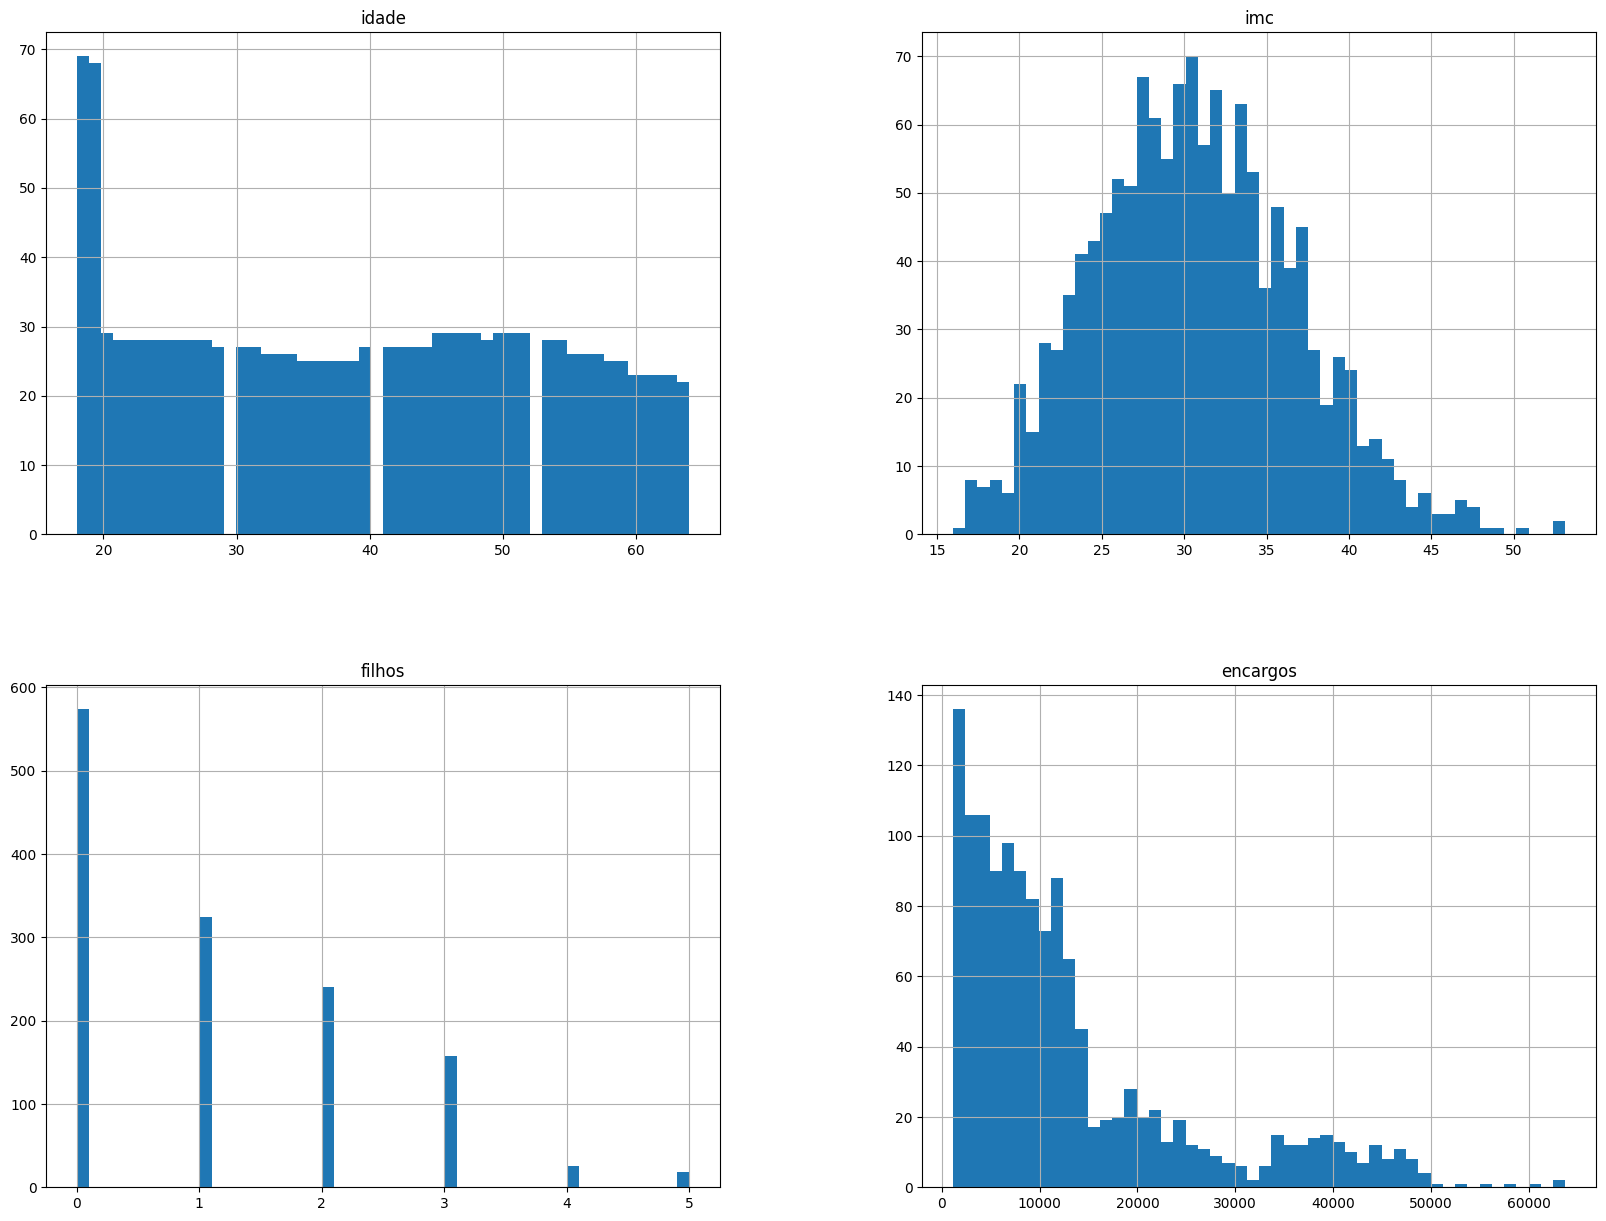

In [8]:
dataset.hist(bins=50, figsize=(20,15))

### 2. Pré-processamento dos dados

- Transformaremos as colunas não-numéricas ("gênero", "fumante" e "região") em numéricas.
- Agruparemos os valores de "imc" em faixas utilizando o LabelEncoder ao invés de OneHotEncoder que aumenta a dimensionalidade.

#### 2.1 Exclusão de registro duplicado e reindexação do dataframe

In [9]:
# dataset.drop_duplicates(inplace=True)
# dataset.reset_index(drop=True, inplace=True)
# dataset.duplicated().sum()

In [10]:
np.random.seed(42)

def preprocess_dataset(dataset, categoriza_imc): 
    dataset_tratado = dataset.copy()
    
    if categoriza_imc:
        dataset_tratado["faixas_imc"] = pd.cut(dataset_tratado["imc"],
                               bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

    label_encoder = LabelEncoder()

    dataset_tratado['genero_type'] = label_encoder.fit_transform(dataset_tratado['gênero'])
    dataset_tratado['fumante_type'] = label_encoder.fit_transform(dataset_tratado['fumante'])
    dataset_tratado['regiao_type'] = label_encoder.fit_transform(dataset_tratado['região'])

    if categoriza_imc:
        dataset_tratado = dataset_tratado.drop(columns = [ "imc", "fumante", "região", "gênero"]).copy()
    else:
        dataset_tratado = dataset_tratado.drop(columns = [ "fumante", "região", "gênero"]).copy()

    return dataset_tratado


In [11]:
dataset_tratado_sem_faixas = preprocess_dataset(dataset, False)
dataset_tratado_sem_faixas.head()

,idade,imc,filhos,encargos,genero_type,fumante_type,regiao_type
0,19,27.900,0,16884.92400,0,1,3
1,18,33.770,1,1725.55230,1,0,2
2,28,33.000,3,4449.46200,1,0,2
3,33,22.705,0,21984.47061,1,0,1
4,32,28.880,0,3866.85520,1,0,1


In [12]:
dataset_tratado = preprocess_dataset(dataset, True)
dataset_tratado.head()

,idade,filhos,encargos,faixas_imc,genero_type,fumante_type,regiao_type
0,19,0,16884.92400,3,0,1,3
1,18,1,1725.55230,4,1,0,2
2,28,3,4449.46200,4,1,0,2
3,33,0,21984.47061,2,1,0,1
4,32,0,3866.85520,3,1,0,1


### 3. Modelagem

Analisando as correlações, apesar de "fumante_type" e "idade" apresentarem uma correlação maior com "encargos", optamos por estratificar as amostras de treino e teste utilizando a coluna "faixas_imc" pelo comportamento "normal" de distribuição na base.

In [13]:
corr_matrix = dataset_tratado.corr()
corr_matrix["encargos"].sort_values(ascending=False)

encargos        1.000000
fumante_type    0.787251
idade           0.299008
faixas_imc      0.205401
filhos          0.067998
genero_type     0.057292
regiao_type    -0.006208
Name: encargos, dtype: float64

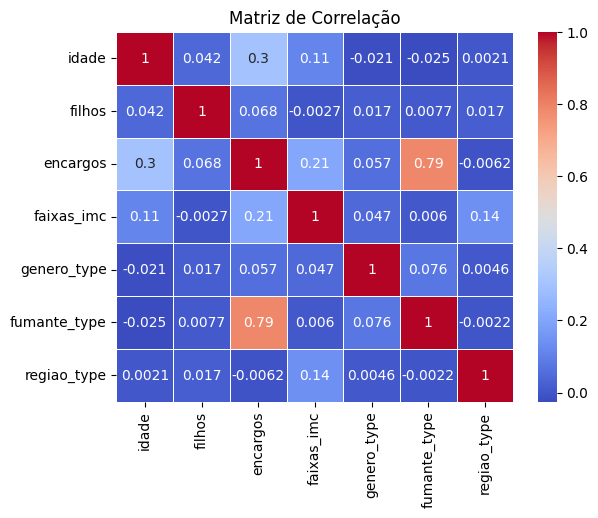

In [14]:
# Exibir o gráfico de correlação usando Seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

#### 3.1 Estratificação das bases de treino e teste

In [15]:
def stratified_dataset(dataset, stratified_shuffle_split):

  if stratified_shuffle_split:
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(dataset, dataset["faixas_imc"]):
        strat_train_set = dataset.loc[train_index]
        strat_test_set = dataset.loc[test_index]

    print("Proporções na base de treino")
    print(strat_train_set["faixas_imc"].value_counts() / len(strat_train_set))
    print("Proporções na base de teste")
    print(strat_test_set["faixas_imc"].value_counts() / len(strat_test_set))

    # Removendo a coluna faixas_imc
    for set_ in (strat_train_set, strat_test_set):
      set_.drop("faixas_imc", axis=1, inplace=True)
  
    X_train = strat_train_set.copy()
    y_train = X_train["encargos"].copy()     

    X_train = X_train.drop(columns=['encargos'], axis=1)

    X_test = strat_test_set.copy()
    y_test = X_test["encargos"].copy()

    X_test = X_test.drop(columns=['encargos'], axis=1)
  
  else:
    X = dataset.drop("encargos", axis=1) # apagando a target para a base de treino (nosso x)
    y = dataset["encargos"].copy() #armazenando a target (nosso y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  return X_train, y_train, X_test, y_test

In [16]:
X_train, y_train, X_test, y_test = stratified_dataset(dataset_tratado, True)
X_train_sem_faixas_imc, y_train_sem_faixas_imc, X_test_sem_faixas_imc, y_test_sem_faixas_imc = stratified_dataset(dataset_tratado_sem_faixas, False)

Proporções na base de treino
faixas_imc
4    0.296262
3    0.284112
5    0.169159
2    0.165421
6    0.069159
1    0.015888
Name: count, dtype: float64
Proporções na base de teste
faixas_imc
4    0.298507
3    0.283582
5    0.167910
2    0.164179
6    0.070896
1    0.014925
Name: count, dtype: float64


### 4. Treinamento, avaliação de vários modelos e validação estatística

- Testaremos vários modelos
    - LinearRegression
    - DecisionTreeRegressor
    - RandomForestRegressor
    - GradientBoostingRegressor
    - HuberRegressor
- Para cada um deles, plotamos um gráfico comparando os valores previstos (eixo Y) com os valores reais (eixo X). Quanto mais próximo da linha ideal, melhor.

In [17]:

def evaluate_model(model, X_train, y_train, y_test, predictions, model_results):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse) 
    r2 = r2_score(y_test, predictions)
    errors = np.abs(y_test - predictions)
    relative_errors = errors / np.abs(y_test)
    mape = np.mean(relative_errors) * 100

    # Cross Validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')

    model_results.append({
        'model': model.__class__.__name__,
        'mae': mae.round(2),
        'mse': mse.round(2),
        'rmse': rmse.round(2),
        'r2': r2.round(4),
        'mape': mape.round(2),
        'K=5 cross-val (r2) mean': scores.mean().round(4),
        'K=5 cross-val (r2) deviation': scores.std().round(4)
    })

    plt.scatter(y_test, predictions)
    plt.xlabel('Encargo Real')
    plt.ylabel('Encargo Previsto')
    
    plt.title('Real vs Previsto - ' + model.__class__.__name__)


    ideal_values = np.linspace(min(y_test), max(y_test)) 
    plt.plot(ideal_values, ideal_values, color='red', label='Ideal')
    plt.legend()
    plt.show()


def run_model(model, X_train, y_train, X_test, y_test, model_results):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    evaluate_model(model, X_train, y_train, y_test, predictions, model_results)


def run_all_models(X_train, y_train, X_test, y_test):
    model_results = []

    models = [
        LinearRegression(),
        DecisionTreeRegressor(),
        GradientBoostingRegressor(),
        RandomForestRegressor(),
        #HuberRegressor()
    ]

    for model in models:
        run_model(model, X_train, y_train, X_test, y_test, model_results)

    return model_results

#### 4.1 Testando os modelos

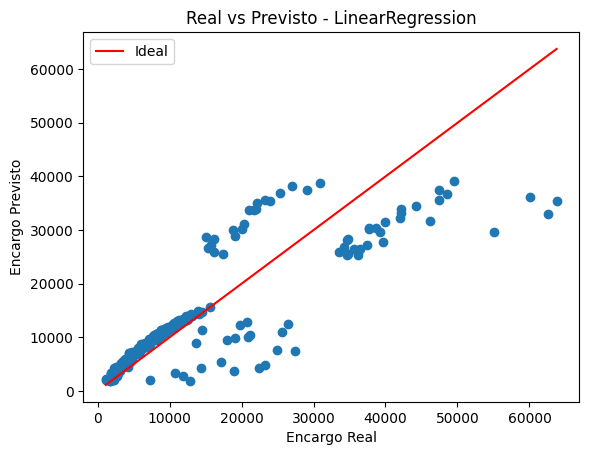

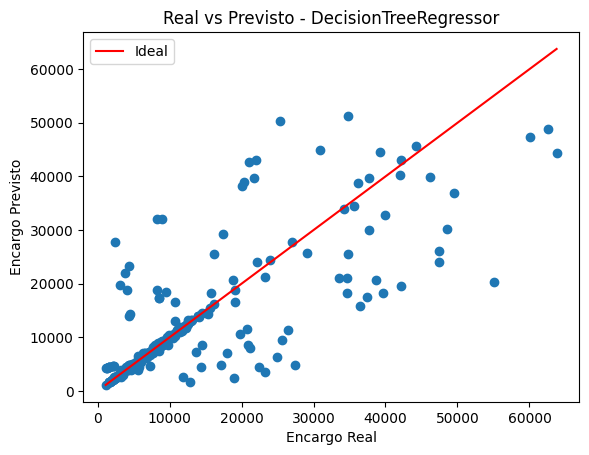

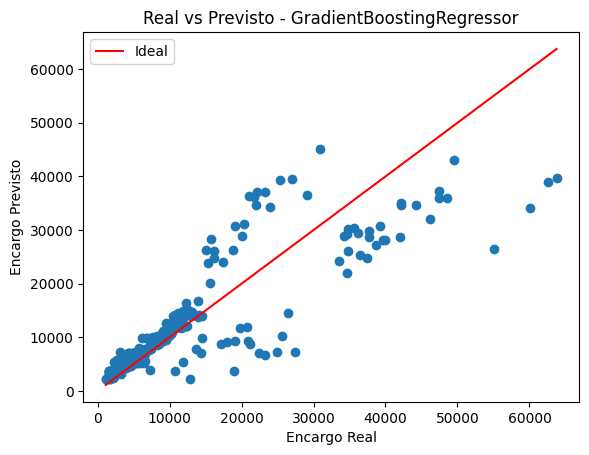

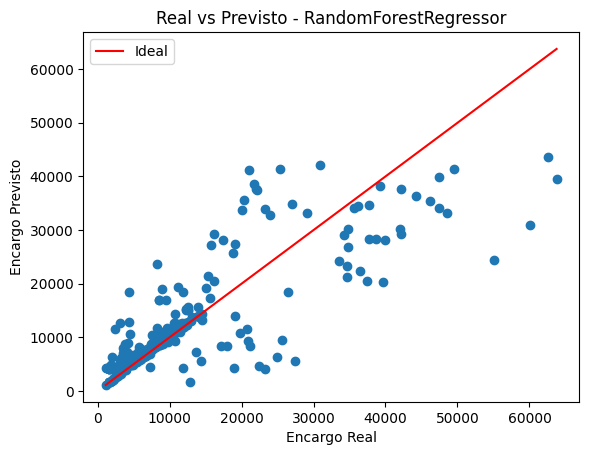

In [18]:
model_results = run_all_models(X_train, y_train, X_test, y_test)

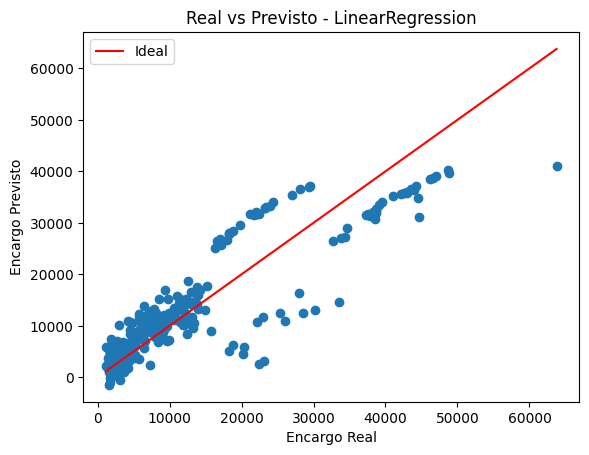

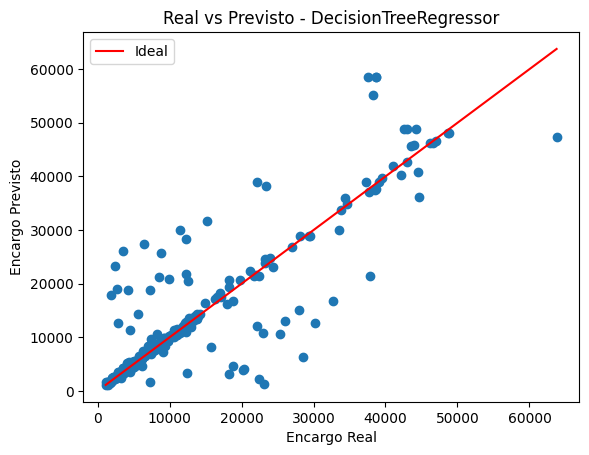

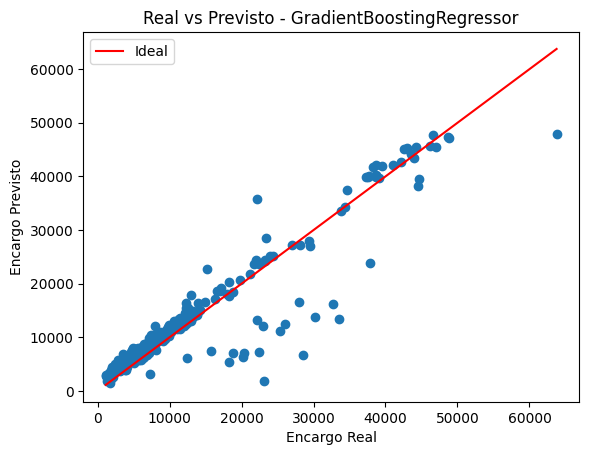

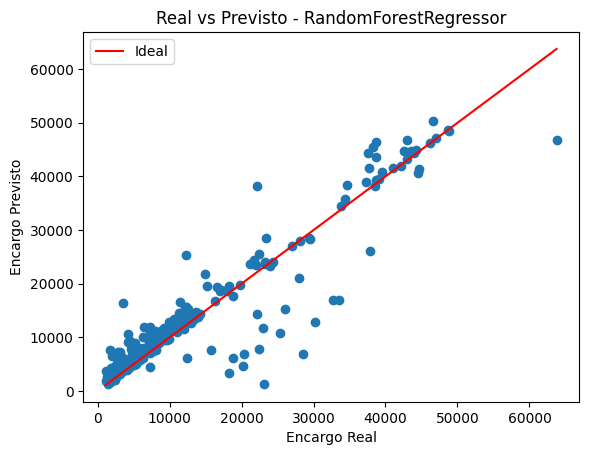

In [19]:
model_results_sem_faixas_imc = run_all_models(X_train_sem_faixas_imc, y_train_sem_faixas_imc, X_test_sem_faixas_imc, y_test_sem_faixas_imc)

#### 4.2 Resultados com categorização do IMC em faixas

In [20]:
model_results_df = pd.DataFrame(model_results)
model_results_df.head()

,model,mae,mse,rmse,r2,mape,K=5 cross-val (r2) mean,K=5 cross-val (r2) deviation
0,LinearRegression,4100.91,42149780.10,6492.29,0.7206,31.83,0.7154,0.0355
1,DecisionTreeRegressor,3907.51,62678520.26,7916.98,0.5845,35.83,0.4593,0.0442
2,GradientBoostingRegressor,3998.64,41482944.64,6440.73,0.7250,34.84,0.7050,0.0353
3,RandomForestRegressor,3976.07,48121673.48,6936.98,0.6810,36.00,0.6503,0.0330


#### 4.3 Resultados sem categorização do IMC

In [21]:
model_results_sem_faixa_imc_df = pd.DataFrame(model_results_sem_faixas_imc)
model_results_sem_faixa_imc_df.head()

,model,mae,mse,rmse,r2,mape,K=5 cross-val (r2) mean,K=5 cross-val (r2) deviation
0,LinearRegression,4186.51,33635210.43,5799.59,0.7833,47.09,0.7398,0.0303
1,DecisionTreeRegressor,2897.98,40200661.63,6340.40,0.7411,31.34,0.7092,0.0509
2,GradientBoostingRegressor,2447.95,18944595.16,4352.54,0.8780,29.25,0.8512,0.0278
3,RandomForestRegressor,2452.88,20729730.67,4552.99,0.8665,28.08,0.8299,0.0234


### 5. Insights e melhorias, re-execução do passo 4

#### 5.1 Análise do valor máximo e médio dos encargos

In [22]:
print("Valor máximo dos encargos:", dataset_tratado['encargos'].max())

Valor máximo dos encargos: 63770.42801


In [23]:
print("Valor médio dos encargos:", dataset_tratado['encargos'].mean())

Valor médio dos encargos: 13270.422265141257


#### 5.2 Análise da variação de amplitude da variável encargos.

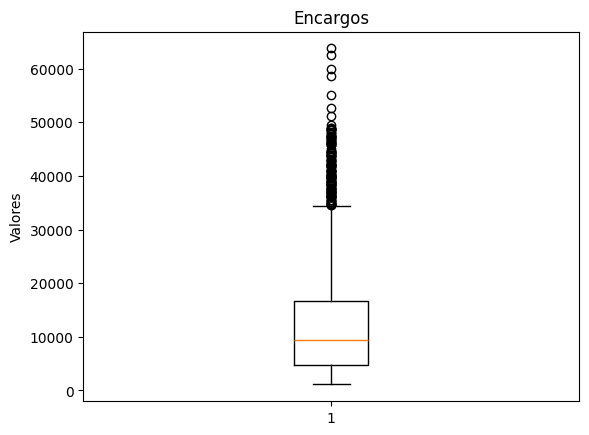

In [24]:
import matplotlib.pyplot as plt

# Criar o gráfico de boxplot
plt.boxplot(dataset_tratado['encargos'])
plt.title('Encargos')
plt.ylabel('Valores')
plt.show()

***Estratégia 1: Observaremos o comportamento dos modelos retirando-se os 25% da base cujo encargo é maior que o 3º quartil***

In [25]:
def recuperar_valor_quartil(data, quartil):
    """
    Calcula o valor do quartil especificado para os dados fornecidos.

    Parâmetros:
        data (array): Array contendo os dados.
        quartil (int): Número do quartil desejado (25, 50 ou 75).

    Retorna:
        float: Valor do quartil especificado.
    """
    return np.percentile(data, quartil)

***Estratégia 1: Exclusão de dados acima do 3º quartil no dataset com faixas_imc***

In [26]:
Q3 = recuperar_valor_quartil(dataset_tratado['encargos'], 75)
dataset_ajustado = dataset_tratado[dataset_tratado['encargos'] <= Q3]
dataset_ajustado.reset_index(drop=True, inplace=True)

X_train, y_train, X_test, y_test = stratified_dataset(dataset_ajustado, True)

Proporções na base de treino
faixas_imc
4    0.298005
3    0.288030
2    0.172070
5    0.155860
6    0.067332
1    0.018703
Name: count, dtype: float64
Proporções na base de teste
faixas_imc
4    0.298507
3    0.288557
2    0.169154
5    0.154229
6    0.069652
1    0.019900
Name: count, dtype: float64


***Estratégia 1: Exclusão de dados acima do 3º quartil no dataset sem categorização por faixas***

In [27]:
Q3 = recuperar_valor_quartil(dataset_tratado_sem_faixas['encargos'], 75)
dataset_ajustado_sem_faixas = dataset_tratado[dataset_tratado['encargos'] <= Q3]
dataset_ajustado_sem_faixas.reset_index(drop=True, inplace=True)

X_train_sem_faixas_imc, y_train_sem_faixas_imc, X_test_sem_faixas_imc, y_test_sem_faixas_imc = stratified_dataset(dataset_ajustado_sem_faixas, True)

Proporções na base de treino
faixas_imc
4    0.298005
3    0.288030
2    0.172070
5    0.155860
6    0.067332
1    0.018703
Name: count, dtype: float64
Proporções na base de teste
faixas_imc
4    0.298507
3    0.288557
2    0.169154
5    0.154229
6    0.069652
1    0.019900
Name: count, dtype: float64


#### 5.3 Testando os modelos com retirada de 25% da base

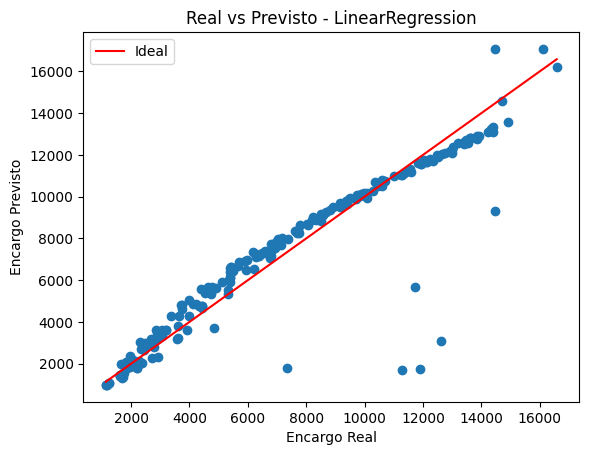

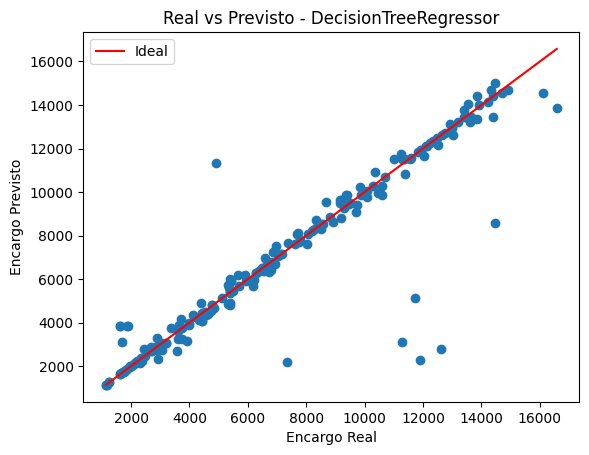

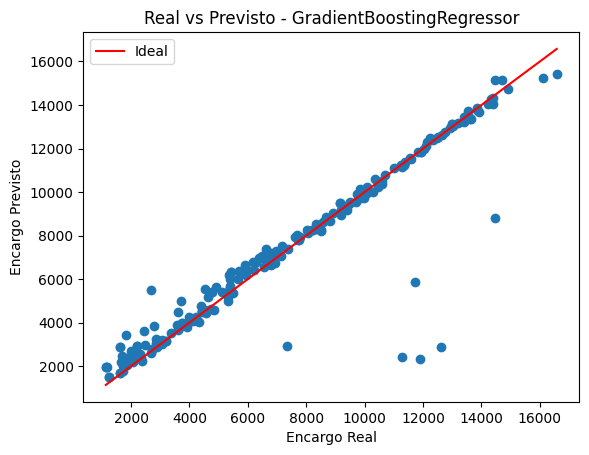

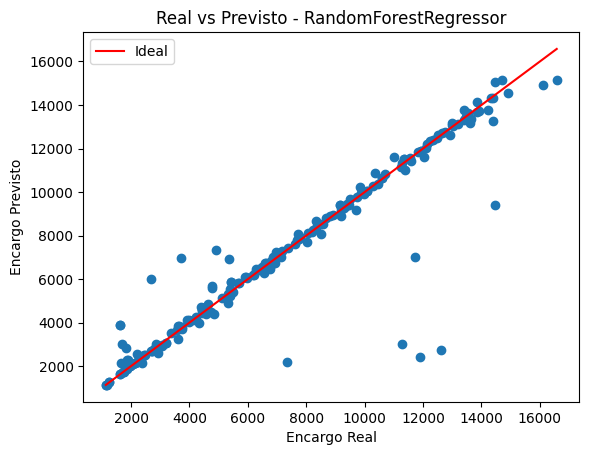

In [28]:
model_results = run_all_models(X_train, y_train, X_test, y_test)

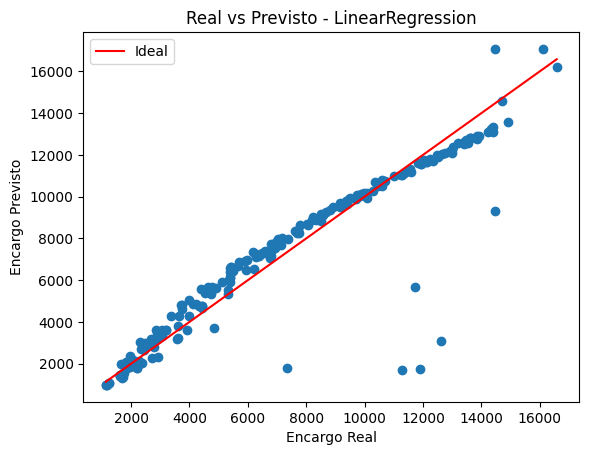

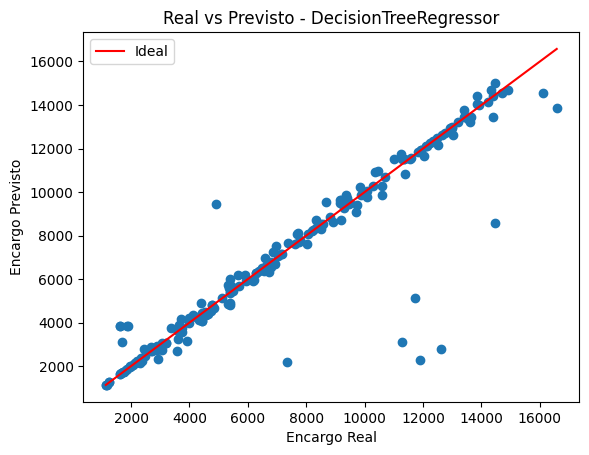

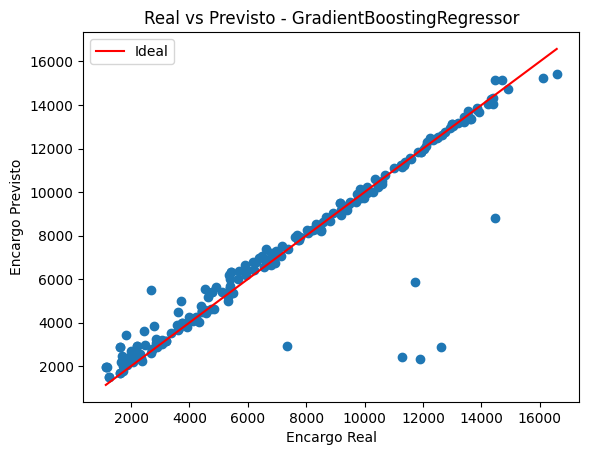

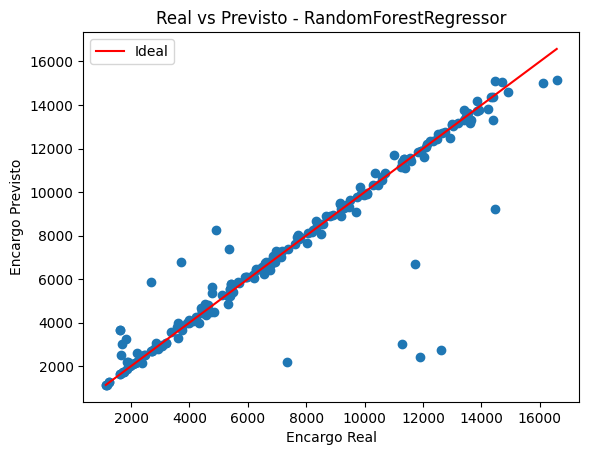

In [29]:
model_results_sem_faixa_imc = run_all_models(X_train_sem_faixas_imc, y_train_sem_faixas_imc, X_test_sem_faixas_imc, y_test_sem_faixas_imc)

#### 5.4 Resultados exclusão de dados acima do 3º quartil e com categorização por faixas imc

In [30]:
model_results_df = pd.DataFrame(model_results)
model_results_df.head()

,model,mae,mse,rmse,r2,mape,K=5 cross-val (r2) mean,K=5 cross-val (r2) deviation
0,LinearRegression,765.08,2301312.40,1517.01,0.8652,11.79,0.8828,0.0375
1,DecisionTreeRegressor,507.13,2223987.53,1491.30,0.8697,8.50,0.8277,0.0818
2,GradientBoostingRegressor,502.97,1944059.49,1394.30,0.8861,10.31,0.8859,0.0420
3,RandomForestRegressor,451.23,1920584.42,1385.85,0.8875,7.92,0.8754,0.0454


#### 5.5 Resultados exclusão de dados acima do 3º quartil e SEM categorização por faixas imc

In [31]:
model_results_sem_faixa_imc_df = pd.DataFrame(model_results_sem_faixa_imc)
model_results_sem_faixa_imc_df.head()

,model,mae,mse,rmse,r2,mape,K=5 cross-val (r2) mean,K=5 cross-val (r2) deviation
0,LinearRegression,765.08,2301312.40,1517.01,0.8652,11.79,0.8828,0.0375
1,DecisionTreeRegressor,487.22,2114569.42,1454.16,0.8761,8.13,0.8238,0.0855
2,GradientBoostingRegressor,502.75,1943968.27,1394.26,0.8861,10.30,0.8859,0.0420
3,RandomForestRegressor,466.06,1961046.20,1400.37,0.8851,8.14,0.8770,0.0457


***Estratégia 2: Utilizaremos upsampling para aumentar a nossa amostra original e verificar o comportamento dos modelos***

In [32]:
upsample_dataset = dataset.sample(n=5000, replace=True, random_state=42, ignore_index=True)

upsample_dataset_tratado = preprocess_dataset(upsample_dataset, True)
upsample_dataset_tratado.describe()

,idade,filhos,encargos,genero_type,fumante_type,regiao_type
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,39.249600,1.074000,13429.083801,0.501800,0.213800,1.517000
std,14.110093,1.181526,12324.765853,0.500047,0.410028,1.106145
min,18.000000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,26.750000,0.000000,4661.286350,0.000000,0.000000,1.000000
50%,39.000000,1.000000,9411.005000,1.000000,0.000000,2.000000
75%,51.000000,2.000000,17468.983900,1.000000,0.000000,2.000000
max,64.000000,5.000000,63770.428010,1.000000,1.000000,3.000000


In [33]:
upsample_dataset_tratado_sem_faixas_imc = preprocess_dataset(upsample_dataset, False)
upsample_dataset_tratado_sem_faixas_imc.describe()

,idade,imc,filhos,encargos,genero_type,fumante_type,regiao_type
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,39.249600,30.604276,1.074000,13429.083801,0.501800,0.213800,1.517000
std,14.110093,6.168745,1.181526,12324.765853,0.500047,0.410028,1.106145
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,26.750000,26.200000,0.000000,4661.286350,0.000000,0.000000,1.000000
50%,39.000000,30.210000,1.000000,9411.005000,1.000000,0.000000,2.000000
75%,51.000000,34.770000,2.000000,17468.983900,1.000000,0.000000,2.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,3.000000


In [34]:
X_train, y_train, X_test, y_test = stratified_dataset(upsample_dataset_tratado, True)
X_train_sem_faixas_imc, y_train_sem_faixas_imc, X_test_sem_faixas_imc, y_test_sem_faixas_imc = stratified_dataset(upsample_dataset_tratado_sem_faixas_imc, False)

Proporções na base de treino
faixas_imc
4    0.28700
3    0.28625
2    0.17050
5    0.16750
6    0.07325
1    0.01550
Name: count, dtype: float64
Proporções na base de teste
faixas_imc
3    0.287
4    0.287
2    0.170
5    0.167
6    0.073
1    0.016
Name: count, dtype: float64


#### 5.6 Testando os modelos com upsampling na amostra original e COM categorização por faixa imc

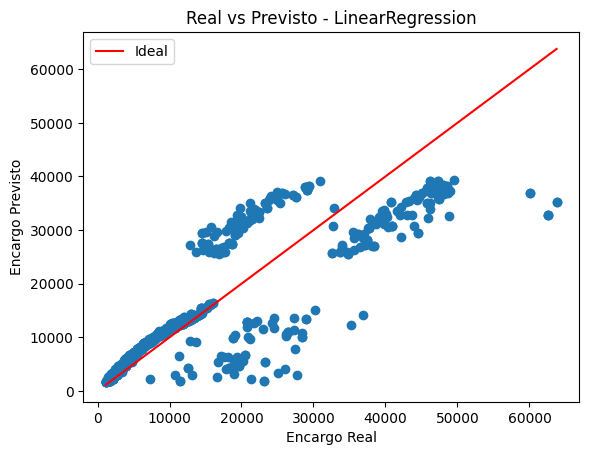

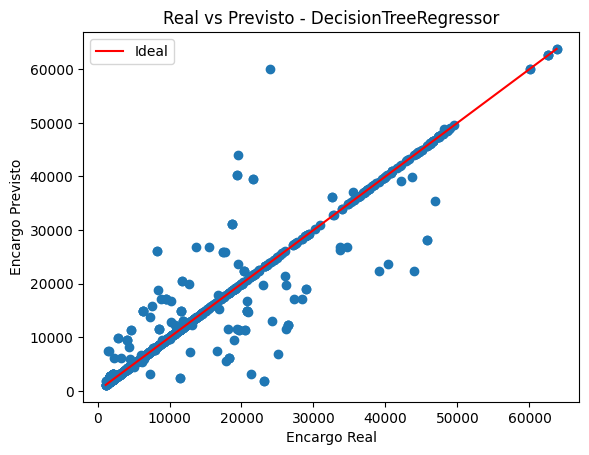

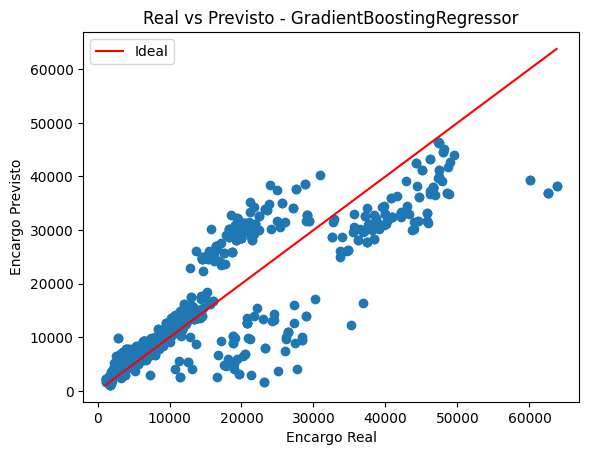

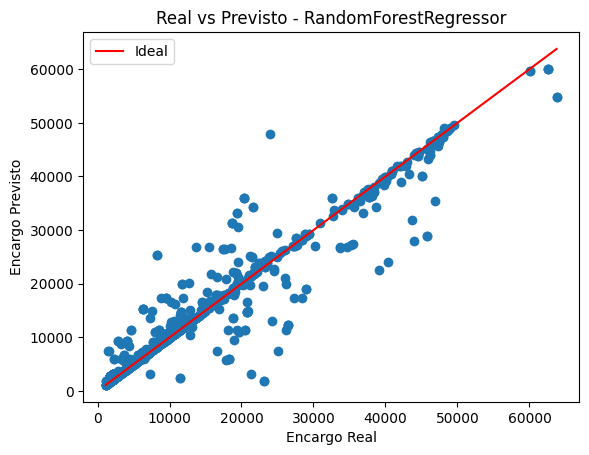

In [35]:
model_results = run_all_models(X_train, y_train, X_test, y_test)

#### 5.6 Testando os modelos com upsampling na amostra original e SEM categorização por faixa imc

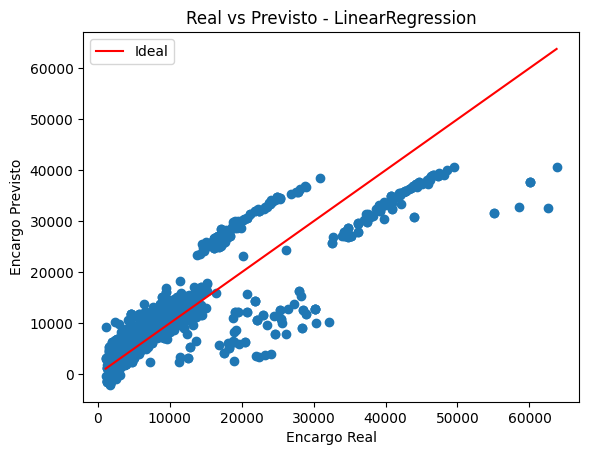

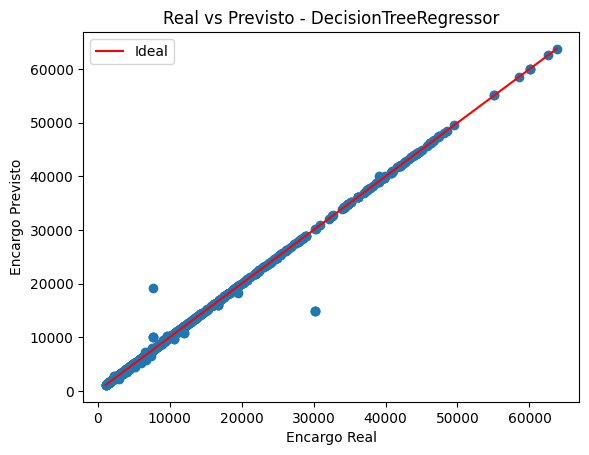

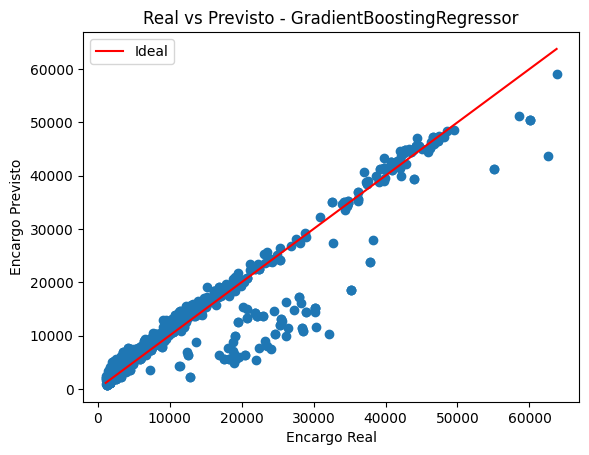

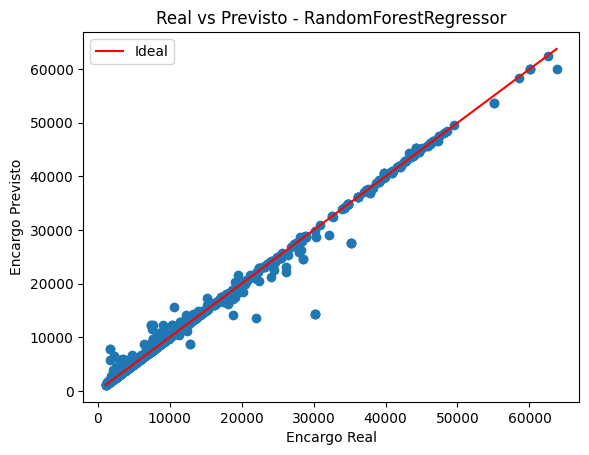

In [36]:
model_results_sem_faixa_imc = run_all_models(X_train_sem_faixas_imc, y_train_sem_faixas_imc, X_test_sem_faixas_imc, y_test_sem_faixas_imc)

#### 5.7 Resultado com upsampling na amostra original e COM categorização por faixa imc

In [37]:
model_results_df = pd.DataFrame(model_results)
model_results_df.head()

,model,mae,mse,rmse,r2,mape,K=5 cross-val (r2) mean,K=5 cross-val (r2) deviation
0,LinearRegression,4220.50,43254922.74,6576.85,0.7271,30.87,0.7246,0.0181
1,DecisionTreeRegressor,1044.61,13094238.17,3618.60,0.9174,9.67,0.9192,0.0159
2,GradientBoostingRegressor,3787.92,35634520.74,5969.47,0.7752,31.15,0.7617,0.0189
3,RandomForestRegressor,1335.05,12512241.28,3537.26,0.9211,11.85,0.9183,0.0069


#### 5.8 Resultado com upsampling na amostra original e SEM categorização por faixa imc

In [38]:
model_results_sem_faixas_imc_df = pd.DataFrame(model_results_sem_faixa_imc)
model_results_sem_faixas_imc_df.head()

,model,mae,mse,rmse,r2,mape,K=5 cross-val (r2) mean,K=5 cross-val (r2) deviation
0,LinearRegression,4143.61,35638251.42,5969.78,0.7539,44.20,0.7482,0.0201
1,DecisionTreeRegressor,82.16,850938.81,922.46,0.9941,0.66,0.9746,0.0062
2,GradientBoostingRegressor,2099.66,15274005.66,3908.20,0.8945,24.35,0.8948,0.0108
3,RandomForestRegressor,392.59,1630060.35,1276.74,0.9887,5.55,0.9787,0.0047
